In [1]:
%load_ext autoreload  
%autoreload 2  
!hostname
!pwd
import sys
print(sys.executable)

isola-2080ti-3.csail.mit.edu
/data/vision/phillipi/akumar01/synthetic-mdps/src
/data/vision/phillipi/akumar01/.virtualenvs/synthetic-mdps/bin/python


In [2]:
import os, sys, glob, pickle

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import optax
from flax import linen as nn
import jax.numpy as jnp
from flax.training.train_state import TrainState
import jax


In [3]:
from compile_experiment import envs_train, envs_test

In [4]:
envs_train

['name=csmdp;i_d=4;i_s=0;t_a=3;t_c=3;t_l=3;t_s=1;o_d=3;o_c=2;r_c=4;tl=64',
 'name=csmdp;i_d=0;i_s=0;t_a=4;t_c=2;t_l=1;t_s=0;o_d=1;o_c=1;r_c=0;tl=64',
 'name=csmdp;i_d=1;i_s=4;t_a=3;t_c=0;t_l=3;t_s=0;o_d=2;o_c=3;r_c=0;tl=64',
 'name=dsmdp;i_d=1;i_s=3;t_a=3;t_s=3;o_d=0;tl=64',
 'name=dsmdp;i_d=1;i_s=1;t_a=1;t_s=0;o_d=2;tl=64',
 'name=dsmdp;i_d=4;i_s=3;t_a=3;t_s=2;o_d=4;tl=64',
 'name=rf;t_a=3;t_c=4;o_d=0',
 'name=rf;t_a=1;t_c=3;o_d=0',
 'name=rf;t_a=0;t_c=1;o_d=4',
 'zero_act']

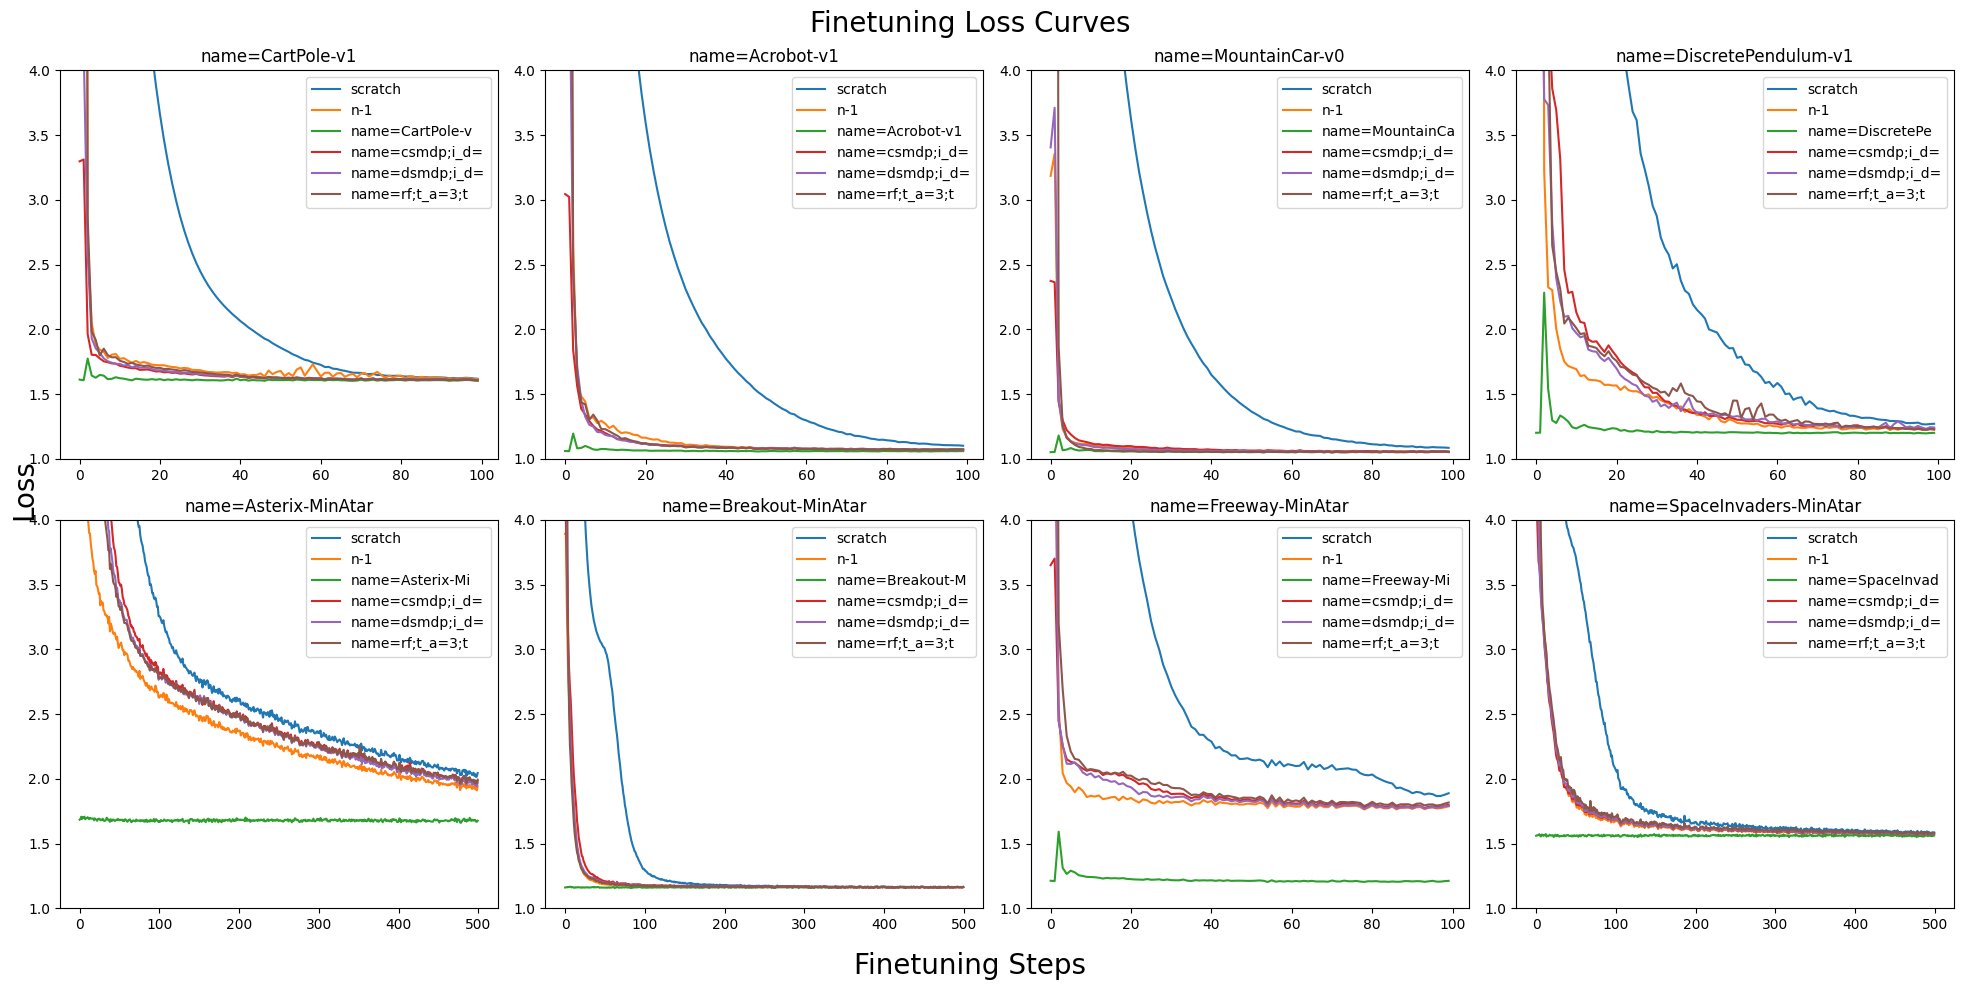

In [46]:
plt.figure(figsize=(20, 10))
for i_plt, env_id_test in enumerate(envs_test):
    plt.subplot(2, 4, i_plt+1)
    plt.title(env_id_test)
    a = [envs_train[0], envs_train[3], envs_train[6]]
    for env_id_train in ['scratch', 'n-1', env_id_test]+a:
        with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/metrics_train.pkl', 'rb') as f:
            metrics_train = pickle.load(f)
        plt.plot(np.exp(metrics_train['loss']), label=env_id_train[:15])
        plt.ylim(1, 4.0)
    plt.legend()
plt.gcf().suptitle("Finetuning Loss Curves", fontsize=20)
plt.gcf().supylabel('Loss', fontsize=20)
plt.gcf().supxlabel('Finetuning Steps', fontsize=20)
plt.tight_layout()
plt.show()

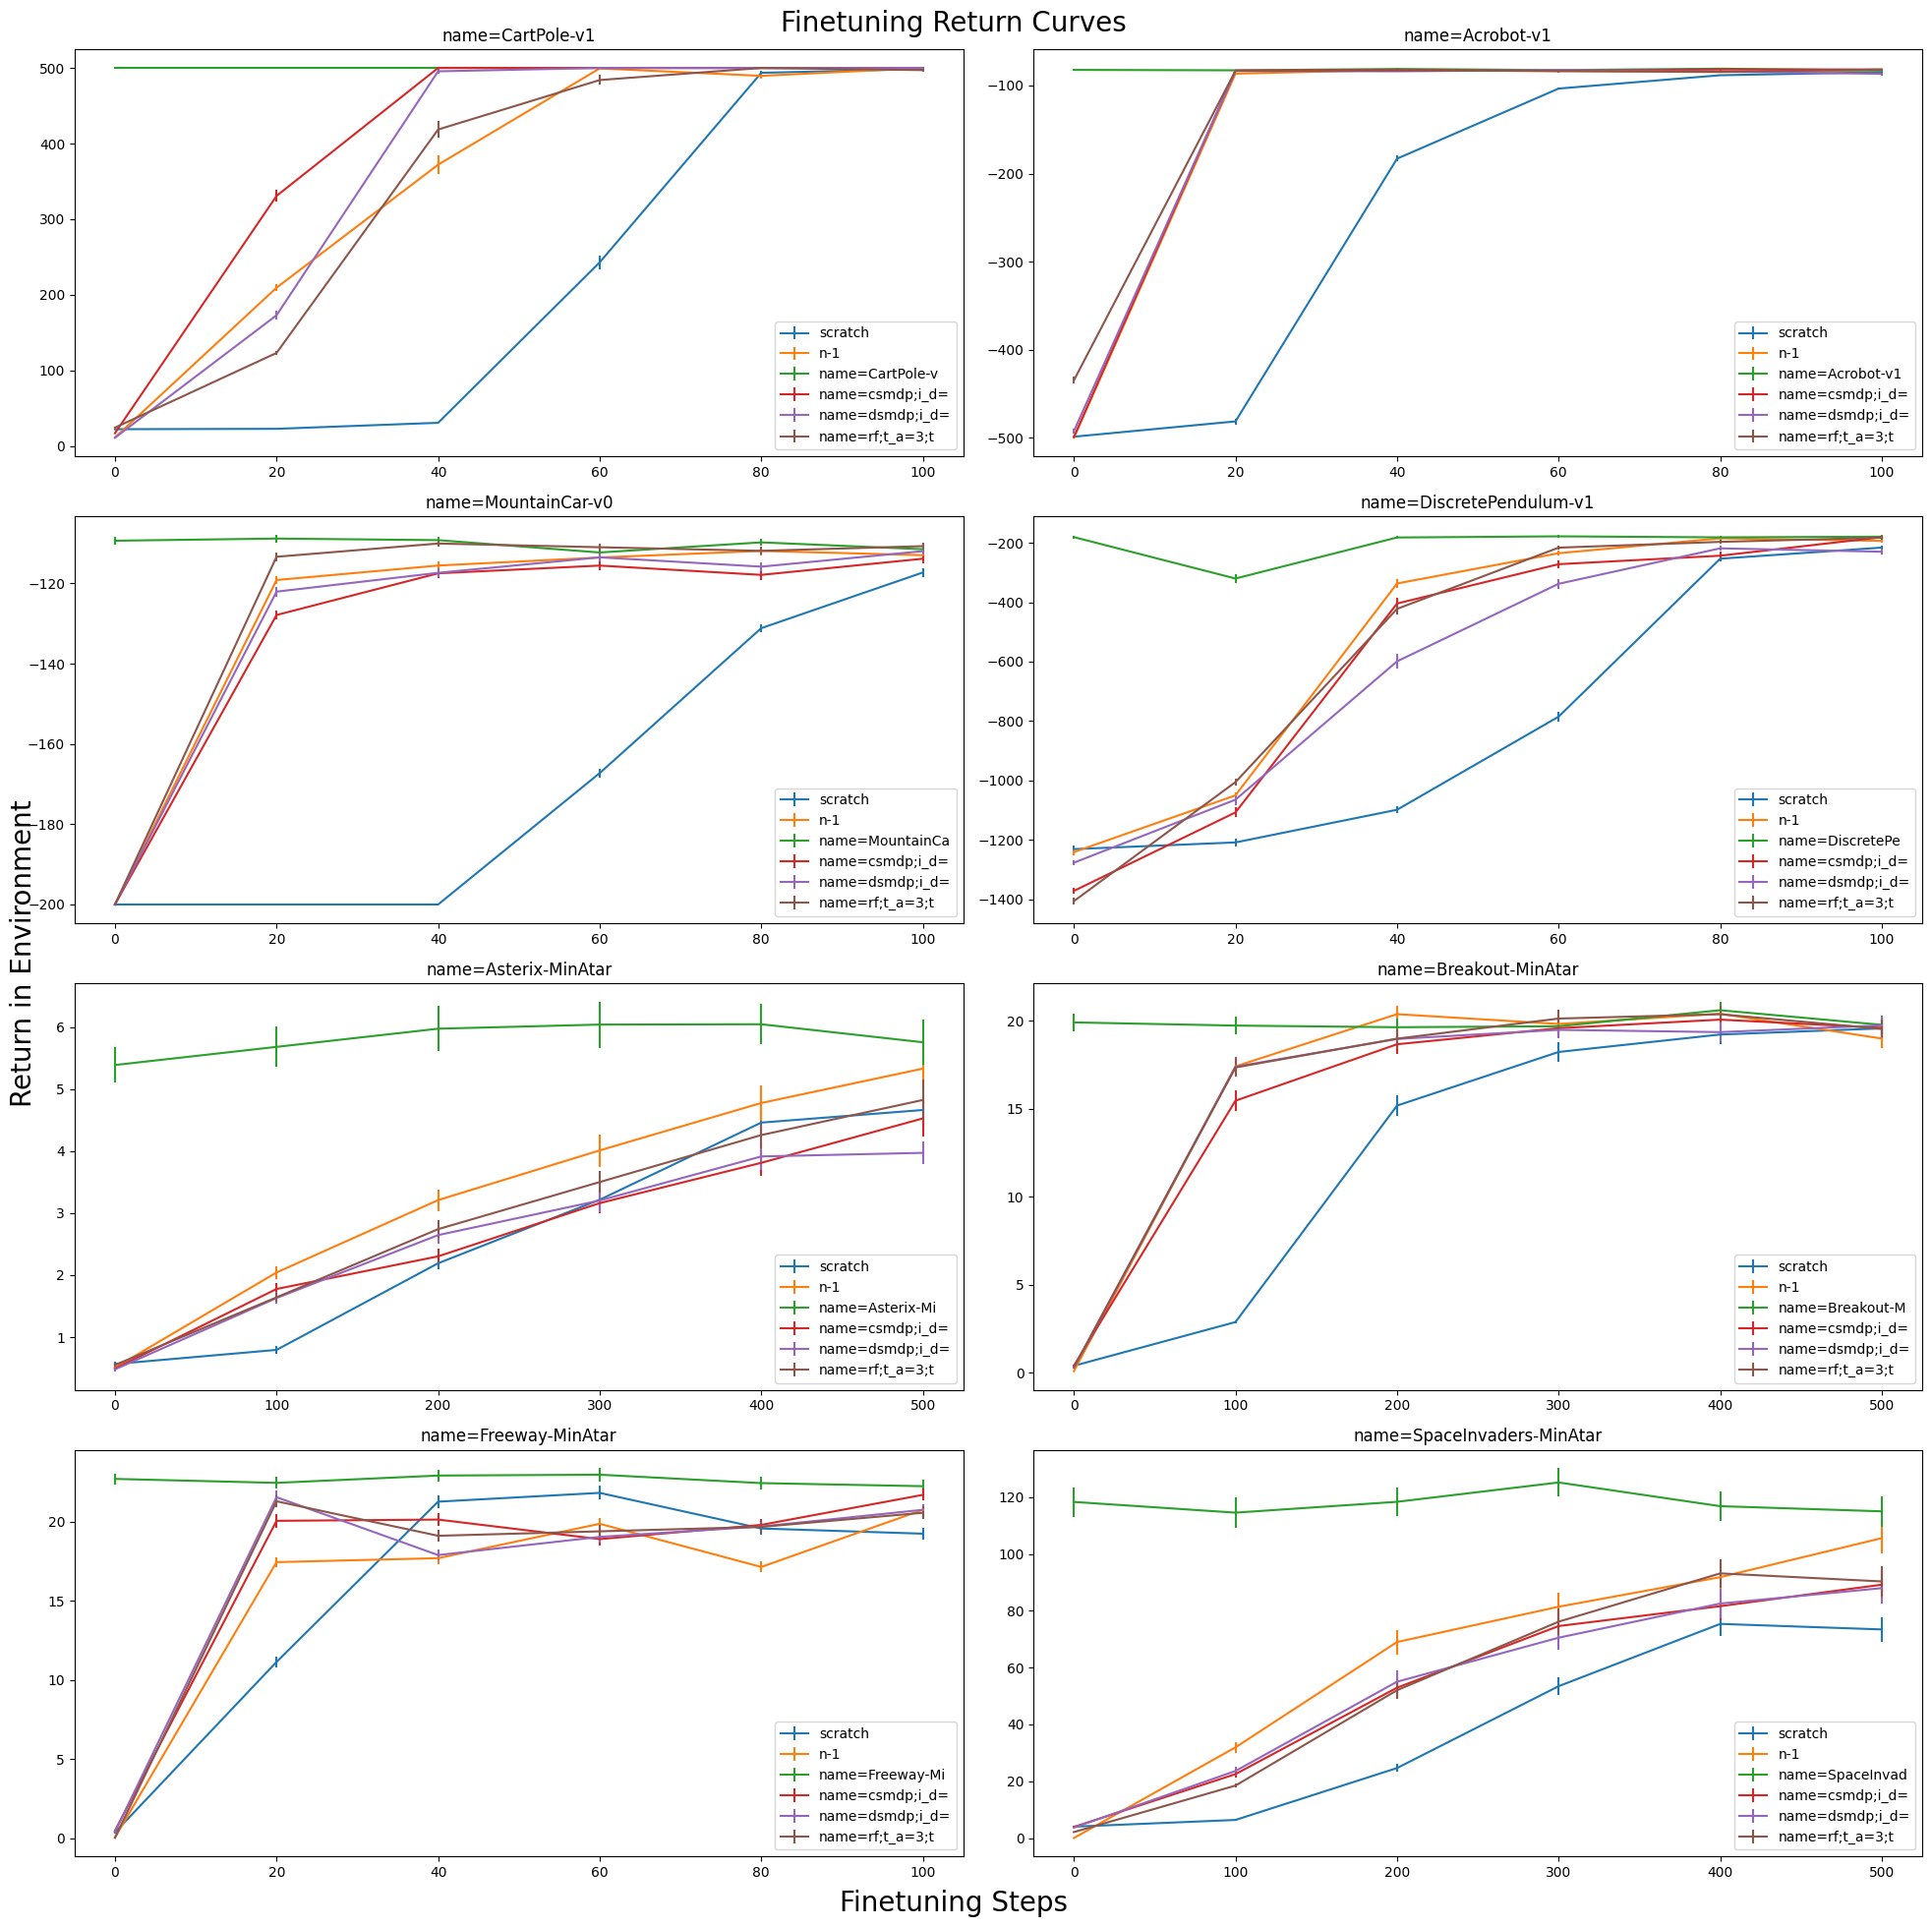

In [47]:
plt.figure(figsize=(20, 20))
for i_plt, env_id_test in enumerate(envs_test):
    plt.subplot(4, 2, i_plt+1)
    plt.title(env_id_test)
    a = [envs_train[0], envs_train[3], envs_train[6]]
    for env_id_train in ['scratch', 'n-1', env_id_test]+a:
        with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/metrics_train.pkl', 'rb') as f:
            metrics_train = pickle.load(f)
        rets = []
        for ckpt in [0, 1, 2, 3, 4, 'final']:
            with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/ckpt_{ckpt}.pkl.unroll.pkl', 'rb') as f:
                rets.append(pickle.load(f)['rets'])
        rets = np.array(rets)
        x = np.linspace(0, len(metrics_train['loss']), 6)[:len(rets)]
        # plt.plot(x, rets.mean(axis=-1), label=env_id_train[:15])
        # with error bars
        plt.errorbar(x, rets.mean(axis=-1), yerr=rets.std(axis=-1)/np.sqrt(rets.shape[-1]), label=env_id_train[:15])
    plt.legend()
plt.gcf().suptitle("Finetuning Return Curves", fontsize=20)
plt.gcf().supylabel('Return in Environment', fontsize=20)
plt.gcf().supxlabel('Finetuning Steps', fontsize=20)
plt.tight_layout()
plt.show()


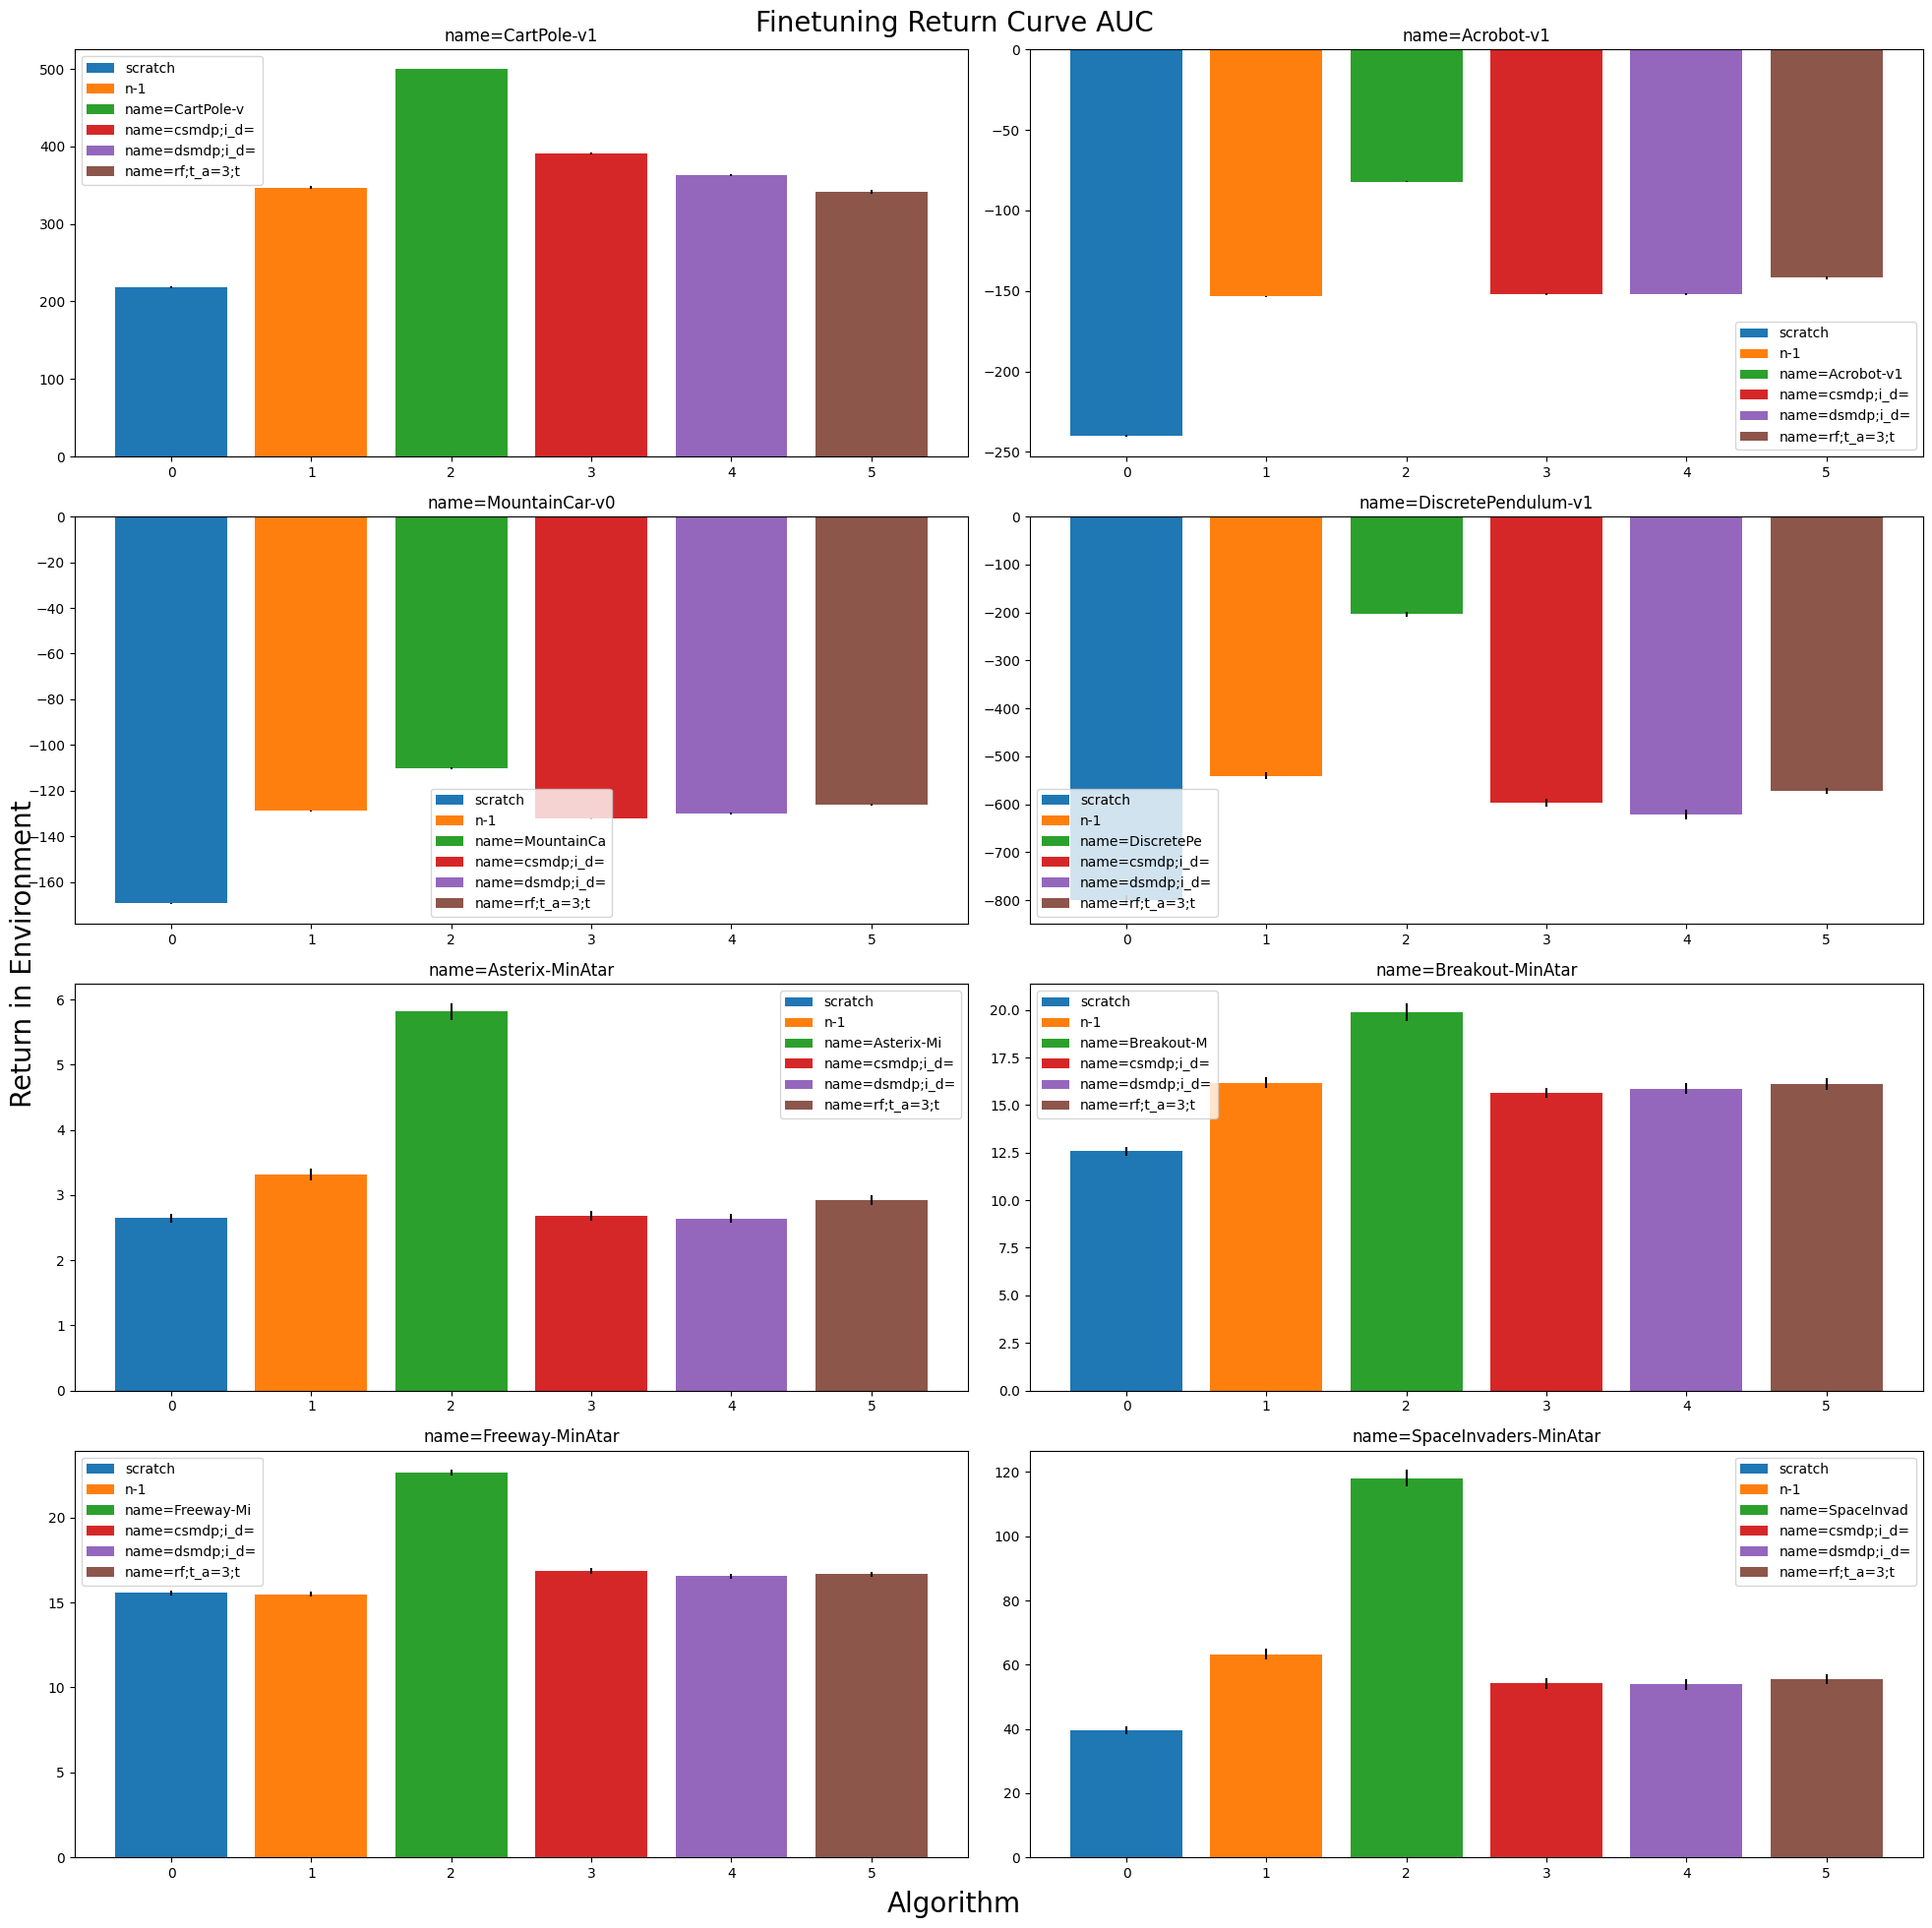

In [48]:
plt.figure(figsize=(20, 20))
for i_plt, env_id_test in enumerate(envs_test):
    plt.subplot(4, 2, i_plt+1)
    plt.title(env_id_test)
    
    for i_train, env_id_train in enumerate(['scratch', 'n-1', env_id_test]+[envs_train[0], envs_train[3], envs_train[6]]):
        with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/metrics_train.pkl', 'rb') as f:
            metrics_train = pickle.load(f)
        rets = []
        for ckpt in [0, 1, 2, 3, 4, 'final']:
            with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/ckpt_{ckpt}.pkl.unroll.pkl', 'rb') as f:
                rets.append(pickle.load(f)['rets'])
        rets = np.array(rets)
        a = rets.mean(axis=0)
        # bar chart with error bars
        plt.bar(i_train, a.mean(), yerr=a.std()/np.sqrt(len(a)), label=env_id_train[:15])
    plt.legend()
plt.gcf().suptitle("Finetuning Return Curve AUC", fontsize=20)
plt.gcf().supylabel('Return in Environment', fontsize=20)
plt.gcf().supxlabel('Algorithm', fontsize=20)
plt.tight_layout()
plt.show()


In [49]:
data = {env_id_test:{} for env_id_test in envs_test}
for i_plt, env_id_test in enumerate(envs_test):
    for i_train, env_id_train in enumerate(['scratch', 'n-1', env_id_test]+[envs_train[0], envs_train[3], envs_train[6]]):
        with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/metrics_train.pkl', 'rb') as f:
            metrics_train = pickle.load(f)
        rets = []
        for ckpt in [0, 1, 2, 3, 4, 'final']:
            with open(f'../data/exp_icl/test_bc/{env_id_test}/{env_id_train}/ckpt_{ckpt}.pkl.unroll.pkl', 'rb') as f:
                rets.append(pickle.load(f)['rets'])
        rets = np.array(rets)
        data[env_id_test][env_id_train] = rets
        
data_norm = {env_id_test:{} for env_id_test in envs_test}
for env_id_test in envs_test:
    low = data[env_id_test]['scratch'].mean()
    high = data[env_id_test][env_id_test].mean()
    for env_id_train in ['scratch', 'n-1', env_id_test]+[envs_train[0], envs_train[3], envs_train[6]]:
        rets = data[env_id_test][env_id_train]
        rets = (rets-low)/(high-low)
        data_norm[env_id_test][env_id_train] = rets

data_norm_unified = {}
for env_id_train in ['scratch', 'n-1', 'oracle']+[envs_train[0], envs_train[3], envs_train[6]]:
    rets = np.stack([data_norm[env_id_test][env_id_test if env_id_train=='oracle' else env_id_train] for env_id_test in envs_test])
    data_norm_unified[env_id_train] = rets.mean(axis=0)

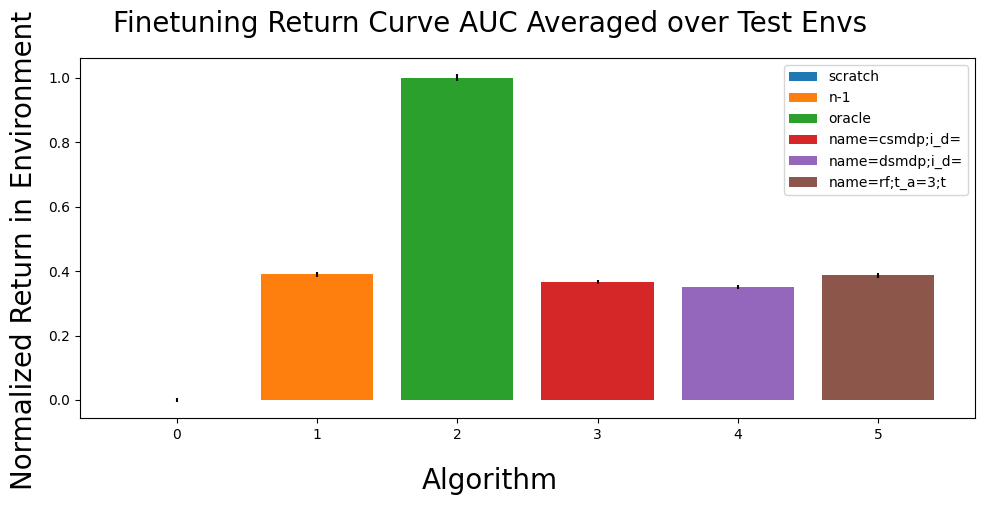

In [54]:
plt.figure(figsize=(10, 5))
for i, env_id_train in enumerate(['scratch', 'n-1', 'oracle']+[envs_train[0], envs_train[3], envs_train[6]]):
    rets = data_norm_unified[env_id_train].mean(axis=0)
    plt.bar(i, rets.mean(), yerr=rets.std()/np.sqrt(len(rets)), label=env_id_train[:15])
plt.legend()
plt.gcf().suptitle("Finetuning Return Curve AUC Averaged over Test Envs", fontsize=20)
plt.gcf().supylabel('Normalized Return in Environment', fontsize=20)
plt.gcf().supxlabel('Algorithm', fontsize=20)
plt.tight_layout()
plt.show()



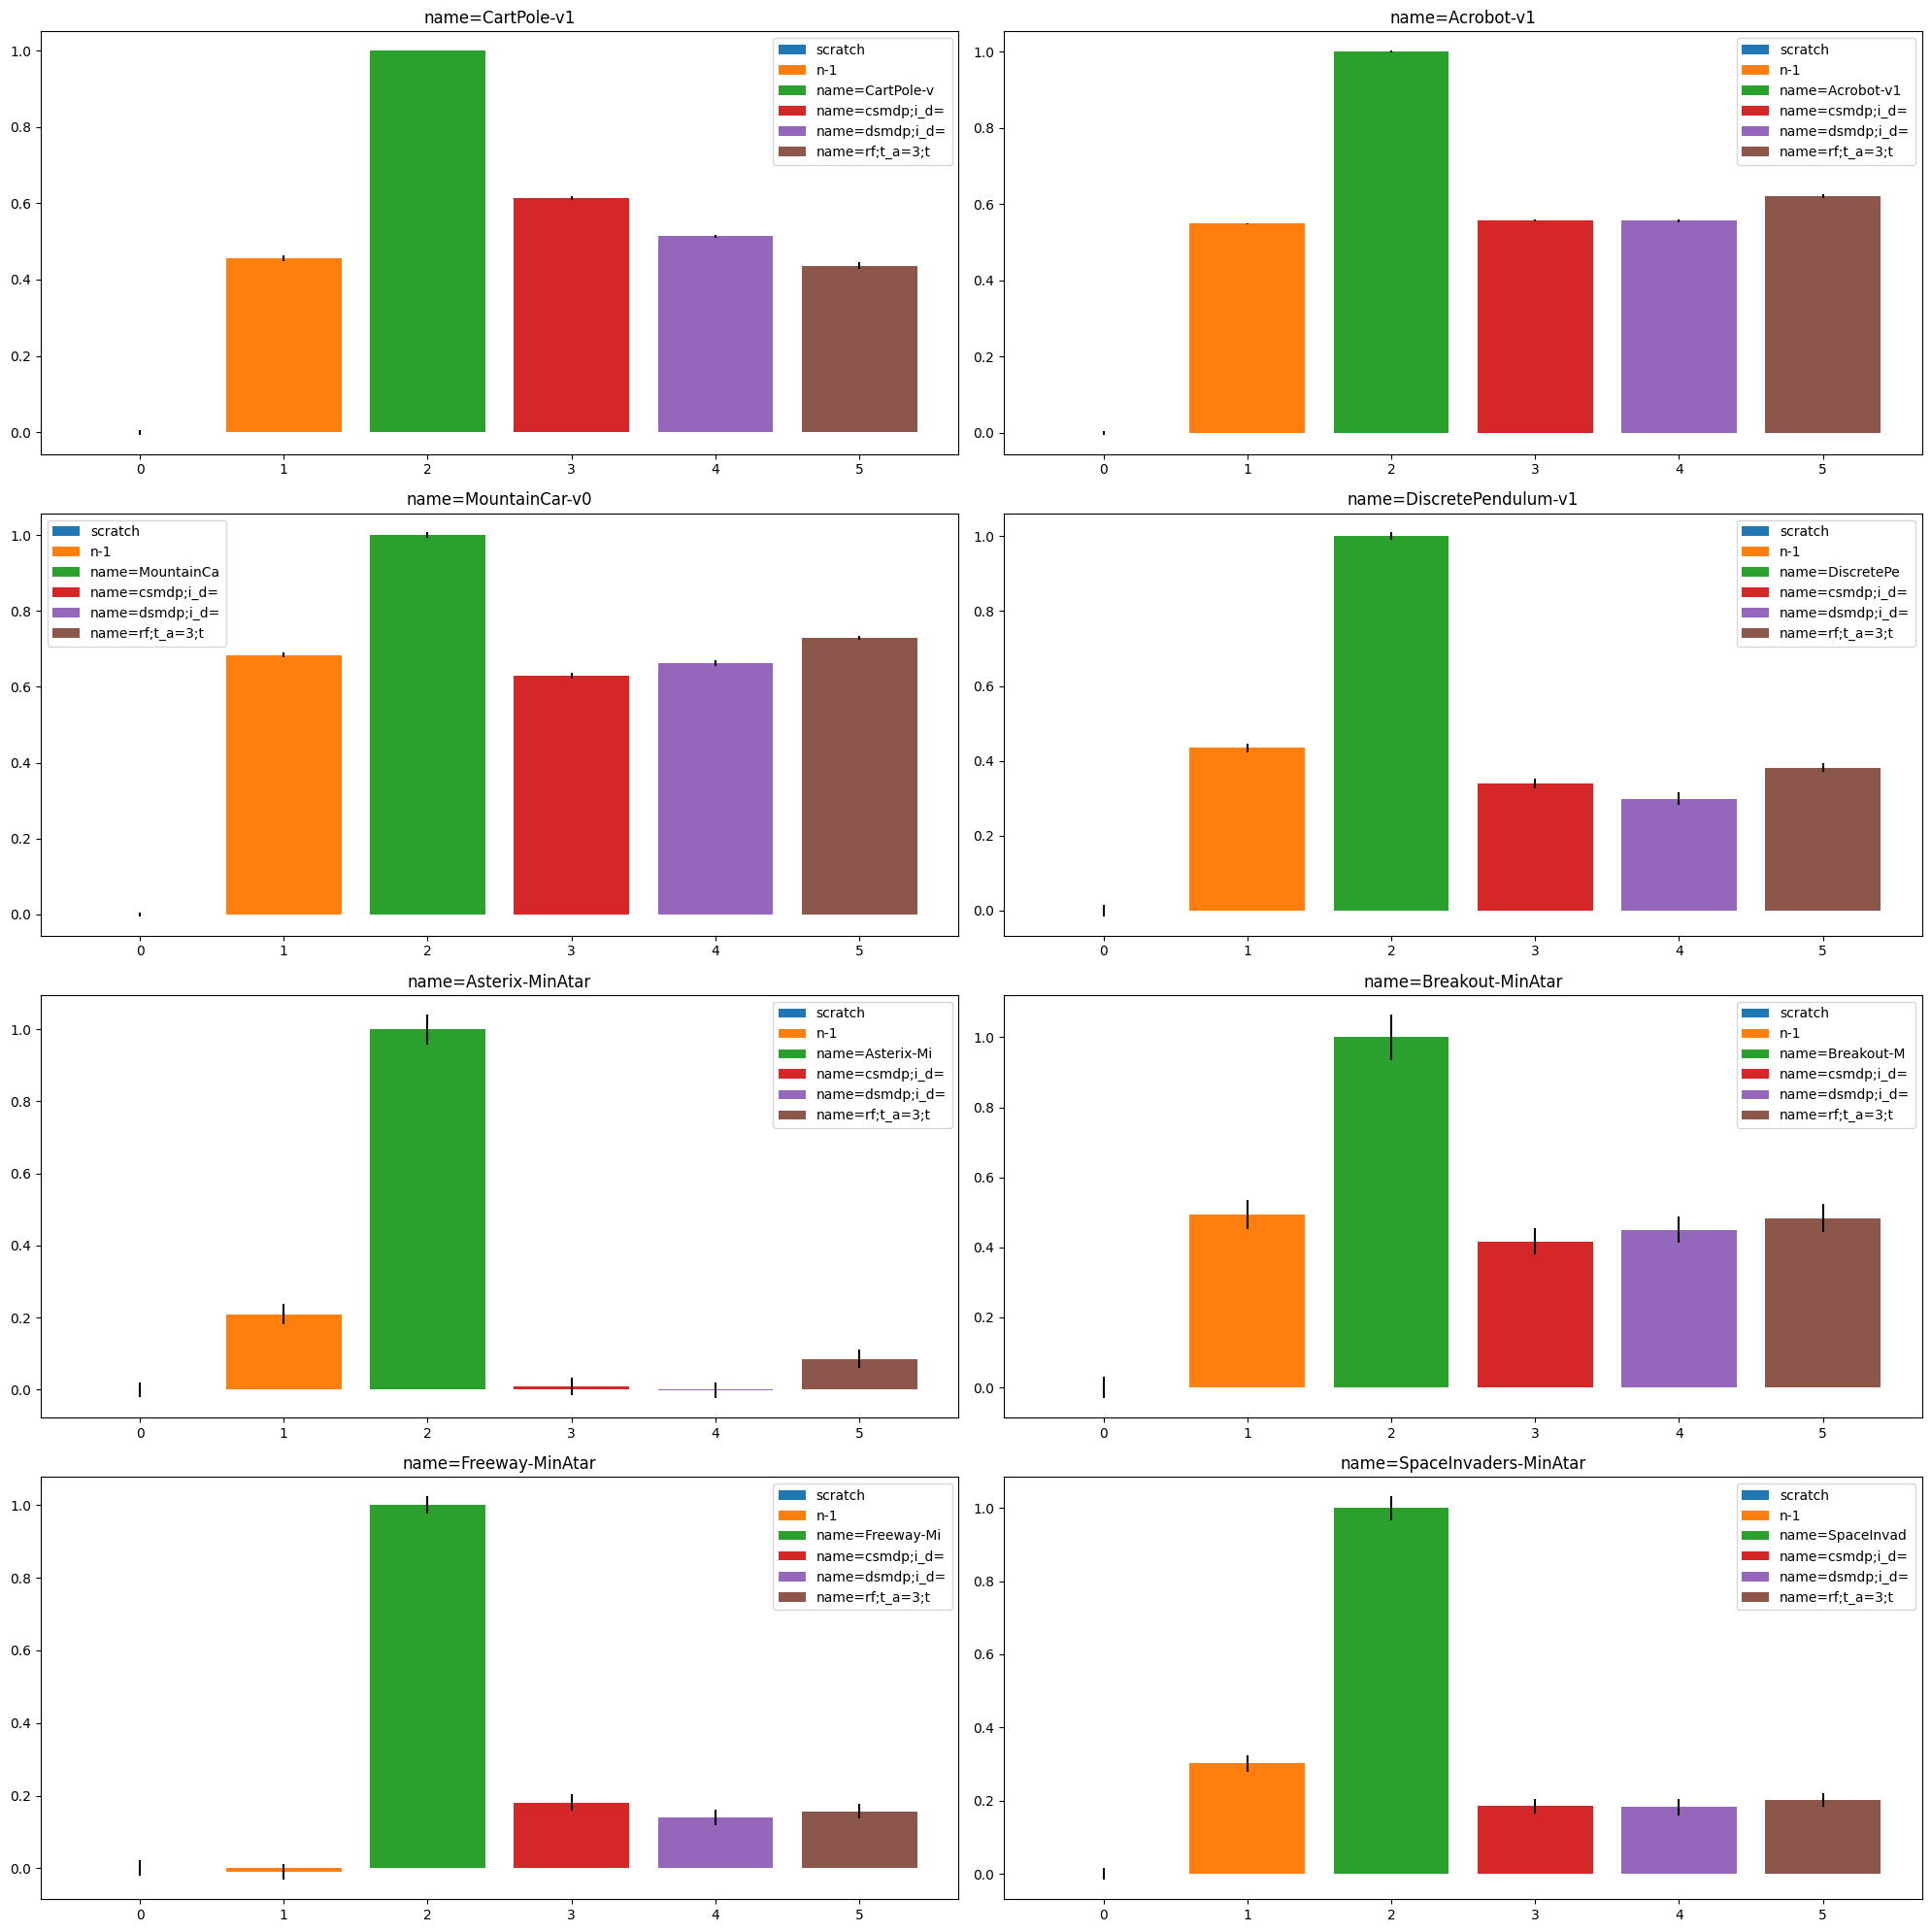

In [30]:
plt.figure(figsize=(20, 20))
for i_plt, env_id_test in enumerate(envs_test):
    plt.subplot(4, 2, i_plt+1)
    plt.title(env_id_test)
    
    low = data[env_id_test]['scratch'].mean()
    high = data[env_id_test][env_id_test].mean()
    
    for i_train, env_id_train in enumerate(['scratch', 'n-1', env_id_test]+[envs_train[0], envs_train[3], envs_train[6]]):
        rets = data[env_id_test][env_id_train]
        rets = (rets-low)/(high-low)
        rets = rets.mean(axis=0)
        plt.bar(i_train, rets.mean(), yerr=rets.std()/np.sqrt(len(rets)), label=env_id_train[:15])
    plt.legend()
plt.tight_layout()
plt.show()


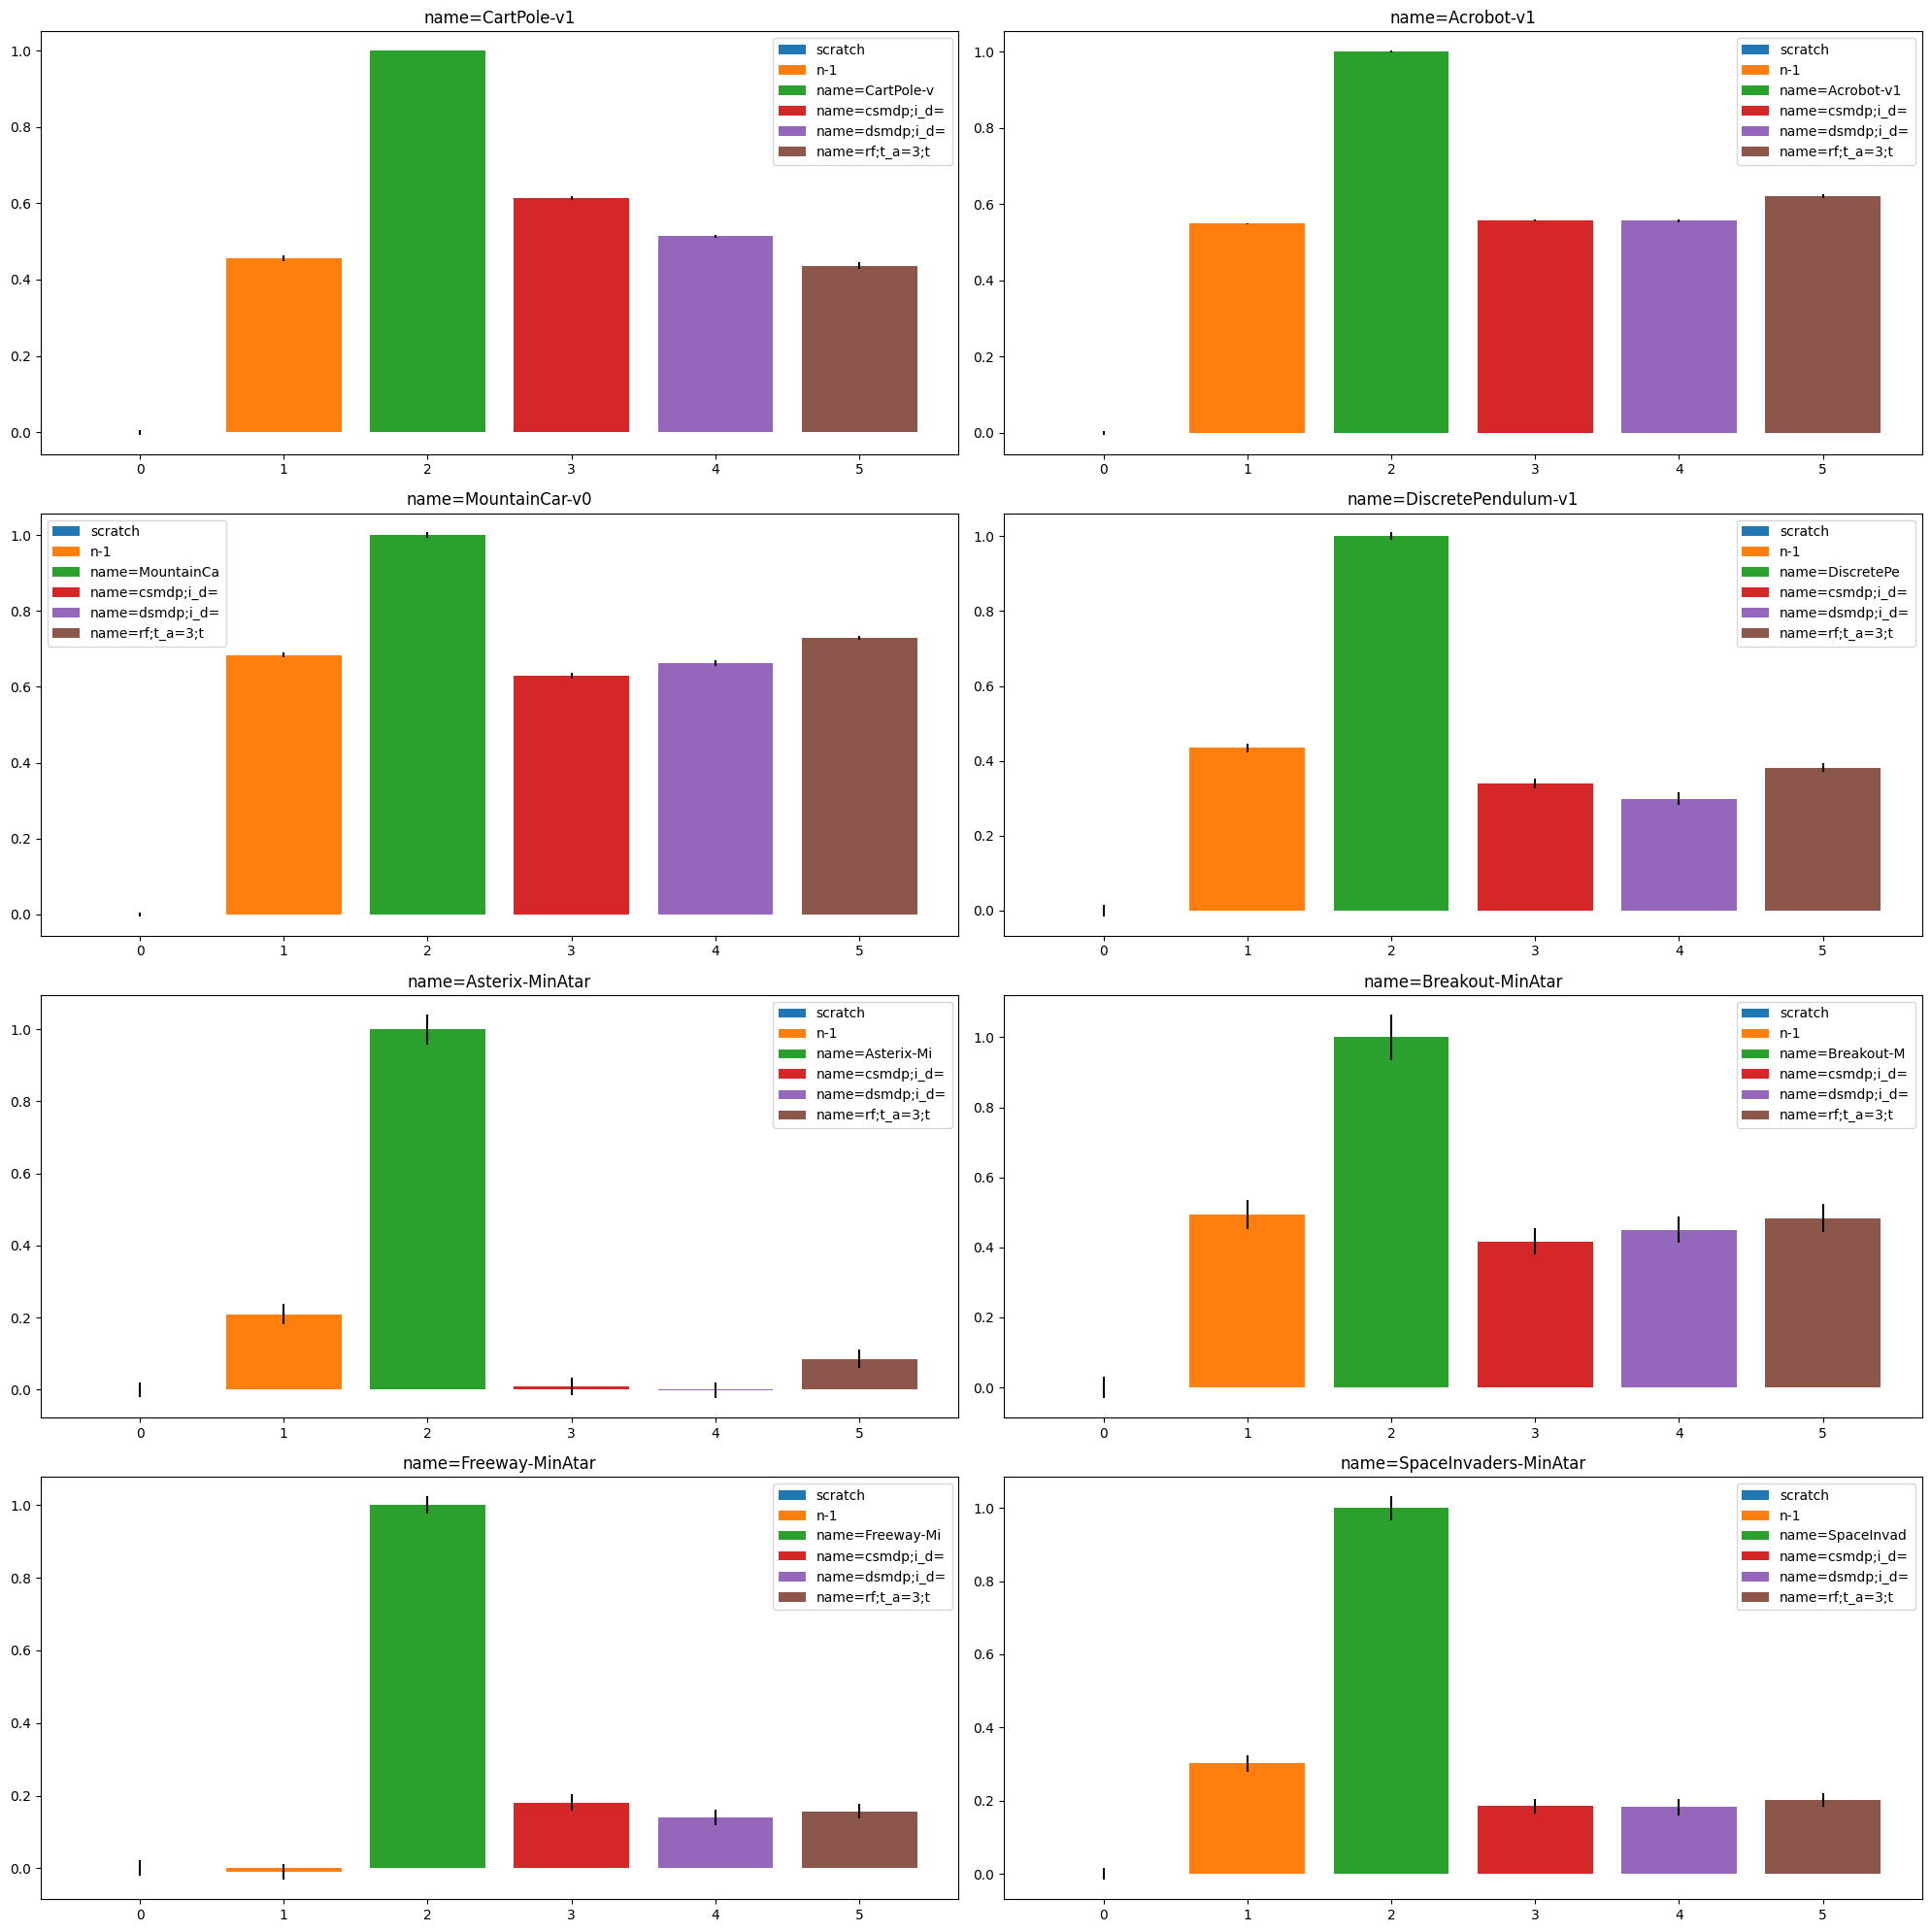

In [31]:
data_norm = 
plt.figure(figsize=(20, 20))
for i_plt, env_id_test in enumerate(envs_test):
    plt.subplot(4, 2, i_plt+1)
    plt.title(env_id_test)
    
    low = data[env_id_test]['scratch'].mean()
    high = data[env_id_test][env_id_test].mean()
    
    for i_train, env_id_train in enumerate(['scratch', 'n-1', env_id_test]+[envs_train[0], envs_train[3], envs_train[6]]):
        rets = data[env_id_test][env_id_train]
        rets = (rets-low)/(high-low)
        rets = rets.mean(axis=0)
        plt.bar(i_train, rets.mean(), yerr=rets.std()/np.sqrt(len(rets)), label=env_id_train[:15])
    plt.legend()
plt.tight_layout()
plt.show()


2024-02-20 23:58:37.962642: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


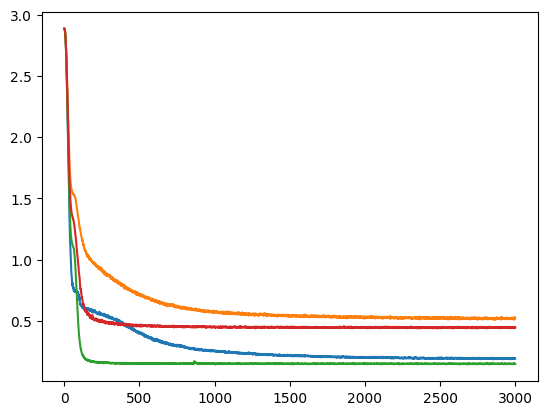

In [6]:
with open(f'../data/exp_icl/train_bc/{"name=Freeway-MinAtar"}/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'])
with open(f'../data/exp_icl/train_bc/{"name=Asterix-MinAtar"}/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'])
with open(f'../data/exp_icl/train_bc/{"name=Breakout-MinAtar"}/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'])
with open(f'../data/exp_icl/train_bc/{"name=SpaceInvaders-MinAtar"}/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'])
# plt.xlim(0, 3000)
# plt.ylim(0.0, 0.8)


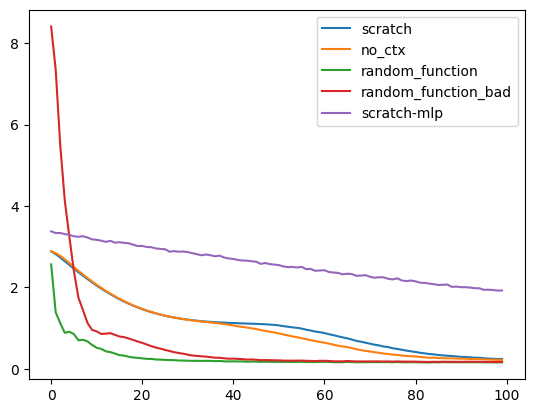

In [172]:
with open(f'../data/exp_icl/test_bc/{"name=Breakout-MinAtar"}/scratch/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'], label='scratch')
with open(f'../data/exp_icl/test_bc/{"name=Breakout-MinAtar"}/no_ctx/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'], label='no_ctx')
with open(f'../data/exp_icl/test_bc/{"name=Breakout-MinAtar"}/random_function/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'], label='random_function')
with open(f'../data/exp_icl/test_bc/{"name=Breakout-MinAtar"}/random_function_bad/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'], label='random_function_bad')
with open(f'../data/exp_icl/test_bc/{"name=Breakout-MinAtar"}/scratch_mlp/metrics_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
plt.plot(metrics_train['loss'], label='scratch-mlp')

plt.legend()
plt.show()


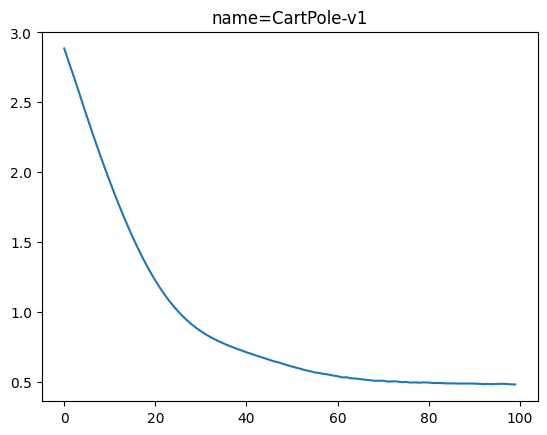

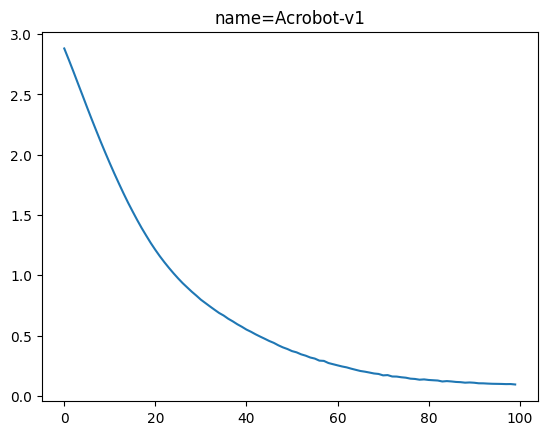

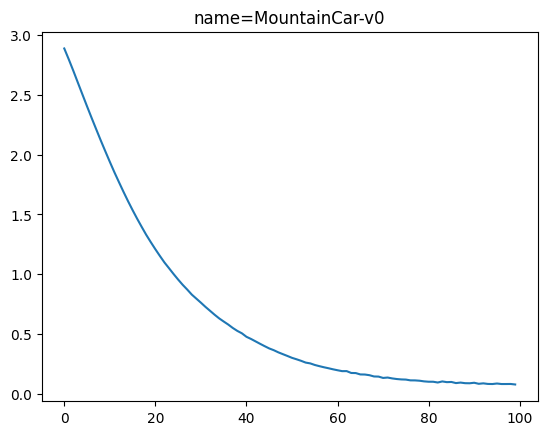

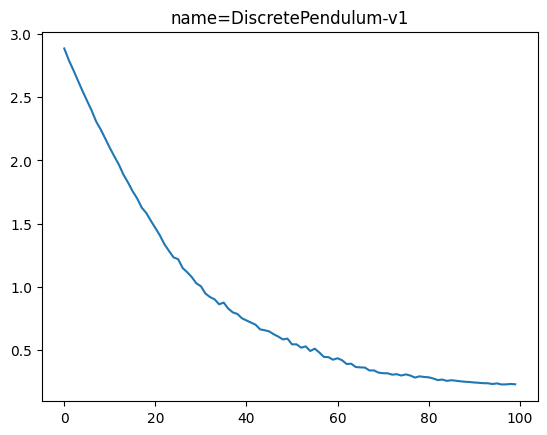

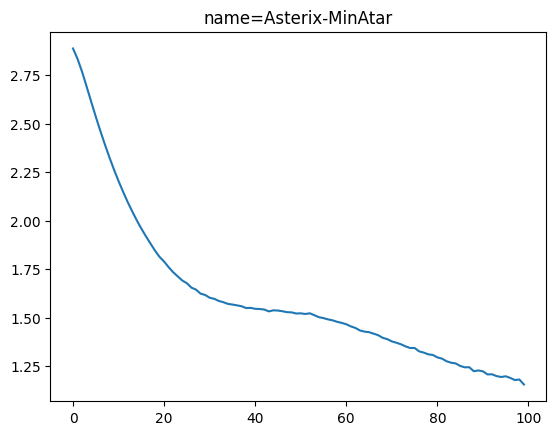

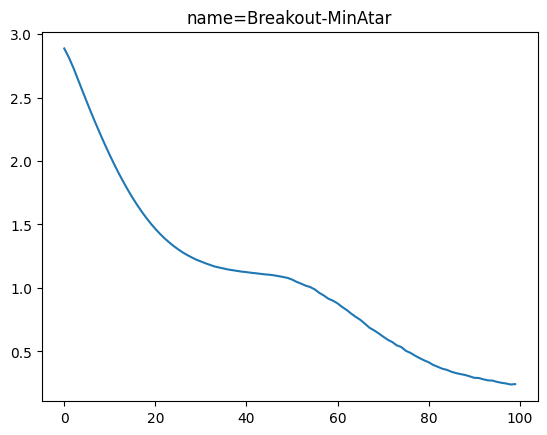

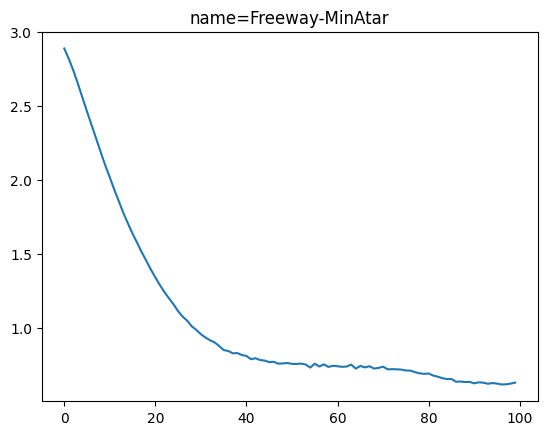

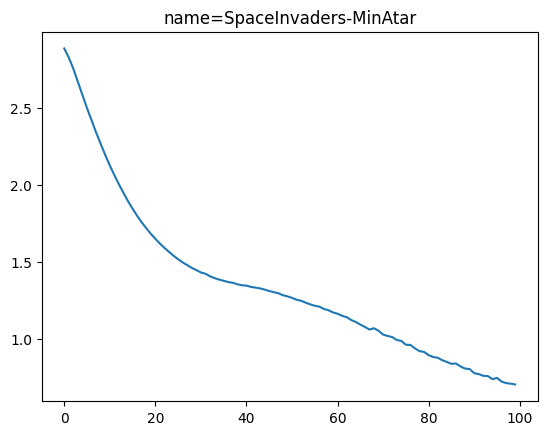

In [38]:
for env_test in envs_test:
    with open(f'../data/exp_icl/test_bc/{env_test}/scratch/metrics_train.pkl', 'rb') as f:
        metrics_train = pickle.load(f)
    plt.plot(metrics_train['loss'])
    plt.title(env_test)
    plt.show()

In [40]:
rng = jax.random.PRNGKey(0)

In [133]:
logits = jax.random.normal(rng, (100, 32))*2
log_probs = jax.nn.log_softmax(logits, axis=-1)
probs = jnp.exp(log_probs)
entr = -(probs*log_probs).sum(axis=-1)
ppl = jnp.exp(entr)
ppl.mean()


Array(8.902796, dtype=float32)

In [142]:
with open("../data/exp_icl/train_bc/random_function/metrics_train.pkl", "rb") as f:
    a = pickle.load(f)

(2000, 128)


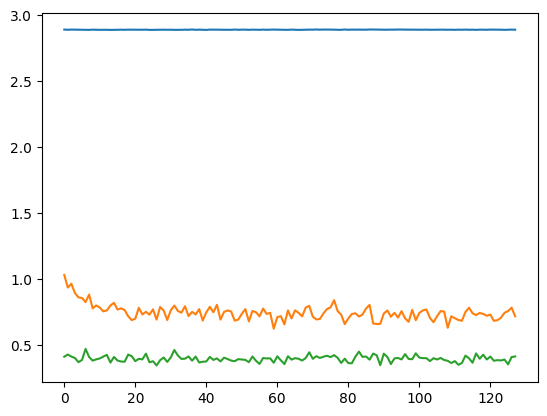

In [152]:
print(a['ce'].shape)
# plt.plot(np.mean(a['ce'], axis=-1))
plt.plot(a['ce'][0])
plt.plot(a['ce'][100])
plt.plot(a['ce'][-1])

